In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import os
import shutil
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import datetime
import gensim
from gensim import corpora



In [128]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to d:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...


True

In [129]:
# Load dataset
df = pd.read_csv("google_play_reviews.csv")  # Ensure the CSV has "Review", "Date", "Rating", and "Version" columns

In [130]:
df.sample(10)

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date
904,Yash,5,17 October 2021,The best app ever that I've never seen/used be...,268 people found this review helpful,CarInfo - Challans| FASTag | Buy & Sell Cars,1 November 2021
601,Dhananjay Kumar,5,31 July 2022,We built a website that helps business owners ...,NaN,NaN,NaN
527,JITESH DESAI,5,5 February 2025,All Details shows Perfect,NaN,NaN,NaN
697,Santosh Kumar,5,27 March 2021,"I am very thankful to the app developer, it's ...",55 people found this review helpful,CarInfo - Challans| FASTag | Buy & Sell Cars,29 March 2021
785,Imran sherif,5,25 March 2025,Good and nice great app,NaN,NaN,NaN
660,Adith Pradeep,4,14 May 2022,Yeah good app. But the only problem is my vehi...,NaN,NaN,NaN
212,Arpit Mehta,5,25 July 2022,"Having read this book, I gained a new perspect...",NaN,NaN,NaN
453,Maneet Singh,5,5 February 2025,Update if we can scan the car owner we also ne...,NaN,NaN,NaN
77,Ankit Maan,5,11 May 2021,App is fantastic and also informative. The car...,463 people found this review helpful,CarInfo - Challans| FASTag | Buy & Sell Cars,22 January 2021
490,A Google user,3,16 January 2019,Do not show exact details. Need few improvment...,18 people found this review helpful,CarInfo - Challans| FASTag | Buy & Sell Cars,16 January 2019


In [131]:
# Convert Date columns to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Handle invalid dates
df['Reply Date'] = pd.to_datetime(df['Reply Date'], errors='coerce')



In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Username    1200 non-null   object        
 1   Rating      1200 non-null   int64         
 2   Date        1200 non-null   datetime64[ns]
 3   Review      1200 non-null   object        
 4   Usefulness  569 non-null    object        
 5   Reply       217 non-null    object        
 6   Reply Date  217 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 65.8+ KB


In [133]:
# Standardize text
df['Review'] = df['Review'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

In [134]:
# Calculate response time (handles NaT and invalid dates)
df['Reply_Time_Days'] = (df['Reply Date'] - df['Date']).dt.days

# Force integer dtype 
df['Reply_Time_Days'] = df['Reply_Time_Days'].astype('Int64') 




In [135]:
# Fill missing Values
df['Reply'].fillna("No Reply", inplace=True)


C:\Users\om\AppData\Local\Temp\ipykernel_10116\60940501.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Reply'].fillna("No Reply", inplace=True)


In [136]:
# Usefulness: Convert to numeric (e.g., "1,234 people found this helpful" → 1234)
df['Usefulness'] = (df['Usefulness'].str.replace(r'[^\d]', '', regex=True).astype('Int64'))
df['Usefulness'] = df['Usefulness'].fillna(0)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Username         1200 non-null   object        
 1   Rating           1200 non-null   int64         
 2   Date             1200 non-null   datetime64[ns]
 3   Review           1200 non-null   object        
 4   Usefulness       1200 non-null   Int64         
 5   Reply            1200 non-null   object        
 6   Reply Date       217 non-null    datetime64[ns]
 7   Reply_Time_Days  217 non-null    Int64         
dtypes: Int64(2), datetime64[ns](2), int64(1), object(3)
memory usage: 77.5+ KB


2. Feature Engineering

In [138]:
sia = SentimentIntensityAnalyzer()
df['Sentiment_Score'] = df['Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['Sentiment'] = pd.cut(df['Sentiment_Score'], 
                         bins=[-1, -0.05, 0.05, 1], 
                         labels=['Negative', 'Neutral', 'Positive'])


In [139]:
import re
import pandas as pd

def detect_device_mentions(reviews_df):
    device_patterns = {
        'iPhone': r'iphone|iOS',
        'Samsung': r'samsung|galaxy',
        'Pixel': r'pixel|google phone',
        'OnePlus': r'oneplus|one plus',
        'Xiaomi': r'xiaomi|redmi|poco',
        'Android': r'\bandroid\b(?!.*(ios|iphone))',
        'iOS': r'\bios\b|apple',
        'Tablet': r'tablet|ipad|galaxy tab'
    }
    
    results = []
    for _, row in reviews_df.iterrows():
        review = str(row['Review']).lower()  # Ensure string conversion
        devices = []
        for device, pattern in device_patterns.items():
            if re.search(pattern, review, flags=re.IGNORECASE):
                devices.append(device)
        results.append({
            'Username': row['Username'],  # Using Username as identifier instead of Review_ID
            'Rating': row['Rating'],
            'Devices_Mentioned': ', '.join(devices) if devices else 'None',
            'Review_Excerpt': review[:100] + '...'  # First 100 chars of review
        })
    
    return pd.DataFrame(results)

# Usage
device_mentions = detect_device_mentions(df)
device_stats = device_mentions['Devices_Mentioned'].value_counts()
print(device_stats)

Devices_Mentioned
None                1196
iPhone                 3
OnePlus, Android       1
Name: count, dtype: int64


In [140]:
# # Length of review
# df['Review_Length'] = df['Review'].apply(len)

# import pandas as pd
# import re

# def extract_device_os_mentions(df):
#     """
#     Extracts mentions of Android and iOS devices/OS from a DataFrame's 'Review' column.
#     """

#     android_regex = r'\b(android(?: \d+)?|samsung|xiaomi|google pixel|oneplus|oppo|huawei|motorola|android device|android phone|android tablet)\b'
#     ios_regex = r'\b(iphone(?: \d+)?|ipad(?: pro| air| mini)?|ios(?: \d+)?|apple device|apple phone|apple tablet)\b'
#     windows_regex = r'\b(windows phone|windows mobile)\b'
#     macos_regex = r'\b(macos|mac os|macintosh)\b'

#     df['Mentions_Android'] = df['Review'].str.contains(android_regex, case=False, regex=True)
#     df['Mentions_iOS'] = df['Review'].str.contains(ios_regex, case=False, regex=True)
#     df['Mentions_WindowsPhone'] = df['Review'].str.contains(windows_regex, case=False, regex=True)
#     df['Mentions_MacOS'] = df['Review'].str.contains(macos_regex, case=False, regex=True)

#     return df

# # Example usage (assuming you have a DataFrame named 'df' with a 'Review' column):
# # df = extract_device_os_mentions(df)

In [141]:
df.head(10)

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive
5,Harish Kumar,1,2025-03-13,it is a useless application i had paid the cha...,5,No Reply,NaT,<NA>,0.5187,Positive
6,Shekhar Mandhotra,1,2025-03-17,very bad experience i pay my bike chllan payme...,0,No Reply,NaT,<NA>,-0.6838,Negative
7,Rajeev Singh,2,2025-03-16,it was a great app now its a scam challans are...,0,No Reply,NaT,<NA>,-0.1406,Negative
8,bala vengat,1,2025-03-12,unable to fastag recharge razarpay gateway pag...,1,No Reply,NaT,<NA>,-0.2960,Negative
9,Pranit Gaikwad,2,2025-03-02,not giving full stars because app doesnt updat...,2,No Reply,NaT,<NA>,0.0680,Positive


3. NLP Processing

In [142]:
import os
import shutil
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. CLEAN SLATE APPROACH
nltk_data_path = r'D:\omnidatax\kult app\scrape_env\nltk_data'
if os.path.exists(nltk_data_path):
    print(f"Removing existing NLTK data at {nltk_data_path}...")
    try:
        shutil.rmtree(nltk_data_path)
    except Exception as e:
        print(f"Couldn't remove directory: {e}")

# 2. FRESH INSTALLATION
print("Performing fresh NLTK data download...")
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)  # Add this line

# 3. VERIFICATION STEPS
print("\nVerifying installation...")
try:
    # Explicitly set the data path
    nltk.data.path = [nltk_data_path]
    
    # Verify the path is set correctly
    print(f"NLTK data paths: {nltk.data.path}")
    
    # Test stopwords
    stop_words = set(stopwords.words('english'))
    print(f"✓ Stopwords loaded successfully (sample: {list(stop_words)[:5]})")
    
    # Test tokenizer
    test_tokens = word_tokenize("This is a test sentence.")
    print(f"✓ Tokenizer working (test tokens: {test_tokens})")
except Exception as e:
    print(f"Verification failed: {e}")
    raise

# Rest of your code...

Removing existing NLTK data at D:\omnidatax\kult app\scrape_env\nltk_data...
Performing fresh NLTK data download...


[nltk_data] Downloading package stopwords to D:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to D:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to D:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.



Verifying installation...
NLTK data paths: ['D:\\omnidatax\\kult app\\scrape_env\\nltk_data']
✓ Stopwords loaded successfully (sample: ['it', 'been', 'my', 'off', 'yourselves'])
✓ Tokenizer working (test tokens: ['This', 'is', 'a', 'test', 'sentence', '.'])


In [143]:
# 1. CLEAN SLATE APPROACH - Remove any potentially corrupted downloads
nltk_data_path = r'D:\omnidatax\kult app\scrape_env\nltk_data'
if os.path.exists(nltk_data_path):
    print(f"Removing existing NLTK data at {nltk_data_path}...")
    try:
        shutil.rmtree(nltk_data_path)
    except Exception as e:
        print(f"Couldn't remove directory: {e}")

# 2. FRESH INSTALLATION
print("Performing fresh NLTK data download...")
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)

# 3. VERIFICATION STEPS
print("\nVerifying installation...")
try:
    # Explicitly set the data path
    nltk.data.path = [nltk_data_path]
    
    # Test stopwords
    stop_words = set(stopwords.words('english'))
    print(f"✓ Stopwords loaded successfully (sample: {list(stop_words)[:5]})")
    
    # Test tokenizer
    test_tokens = word_tokenize("This is a test sentence.")
    print(f"✓ Tokenizer working (test tokens: {test_tokens})")
except Exception as e:
    print(f"Verification failed: {e}")
    raise

# 4. PROCESSING FUNCTION WITH ERROR HANDLING
def preprocess(text):
    try:
        words = word_tokenize(str(text))
        return [word for word in words if word.isalpha() and word not in stop_words]
    except Exception as e:
        print(f"Error processing text: {str(text)[:50]}... Error: {e}")
        return []

# 5. PROCESS DATA IN CHUNKS
print("\nProcessing reviews...")
chunk_size = 100
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    df.loc[chunk.index, 'Tokens'] = chunk['Review'].apply(preprocess)
    print(f"Processed {min(i+chunk_size, len(df))}/{len(df)} reviews")

print("✅ Text preprocessing completed successfully!")


Removing existing NLTK data at D:\omnidatax\kult app\scrape_env\nltk_data...
Performing fresh NLTK data download...


[nltk_data] Downloading package stopwords to D:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to D:\omnidatax\kult
[nltk_data]     app\scrape_env\nltk_data...


[nltk_data]   Unzipping tokenizers\punkt.zip.



Verifying installation...
✓ Stopwords loaded successfully (sample: ['it', 'been', 'my', 'off', 'yourselves'])
✓ Tokenizer working (test tokens: ['This', 'is', 'a', 'test', 'sentence', '.'])

Processing reviews...
Processed 100/1200 reviews
Processed 200/1200 reviews
Processed 300/1200 reviews
Processed 400/1200 reviews
Processed 500/1200 reviews
Processed 600/1200 reviews
Processed 700/1200 reviews
Processed 800/1200 reviews
Processed 900/1200 reviews
Processed 1000/1200 reviews
Processed 1100/1200 reviews
Processed 1200/1200 reviews
✅ Text preprocessing completed successfully!


In [144]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,"[application, cool, helpful, searches, driving..."
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,"[app, lot, information, however, ads, major, p..."
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,"[app, useful, efficient, problem, pictures, ve..."
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,"[app, amazing, performance, poor, took, insura..."
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,"[great, app, good, downloads, ratings, use, th..."


In [145]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['Tokens']]

# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Show topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")
# import gensim
# from gensim import corpora
# from gensim.models import CoherenceModel
# import pandas as pd
# import logging

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# def perform_lda_topic_modeling(df, tokens_column='Tokens', num_topics=5, passes=15):
#     """
#     Performs LDA topic modeling on a DataFrame's tokenized text data.

#     Args:
#         df (pd.DataFrame): DataFrame containing the tokenized text.
#         tokens_column (str): Name of the column containing the tokens.
#         num_topics (int): Number of topics to discover.
#         passes (int): Number of training passes.

#     Returns:
#         tuple: (lda_model, dictionary, corpus, coherence_score)
#     """
#     try:
#         dictionary = corpora.Dictionary(df[tokens_column])
#         corpus = [dictionary.doc2bow(tokens) for tokens in df[tokens_column]]

#         lda_model = gensim.models.LdaModel(
#             corpus, num_topics=num_topics, id2word=dictionary, passes=passes
#         )

#         coherence_model = CoherenceModel(
#             model=lda_model, texts=df[tokens_column], dictionary=dictionary, coherence='c_v'
#         )
#         coherence_score = coherence_model.get_coherence()

#         logging.info(f"Coherence Score: {coherence_score}")

#         for idx, topic in lda_model.print_topics():
#             logging.info(f"Topic {idx}: {topic}")

#         return lda_model, dictionary, corpus, coherence_score

#     except Exception as e:
#         logging.error(f"Error during LDA: {e}")
#         return None, None, None, None
    
    

# Example usage (assuming 'df' and 'Tokens' exist):
# lda_model, dictionary, corpus, coherence = perform_lda_topic_modeling(df, num_topics=7)
# if lda_model:
#     # Use the model, dictionary, and corpus
#     pass

2025-03-27 21:06:34,624 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-03-27 21:06:34,906 : INFO : built Dictionary<3127 unique tokens: ['app', 'appearance', 'application', 'assurance', 'better']...> from 1200 documents (total 19881 corpus positions)
2025-03-27 21:06:34,913 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<3127 unique tokens: ['app', 'appearance', 'application', 'assurance', 'better']...> from 1200 documents (total 19881 corpus positions)", 'datetime': '2025-03-27T21:06:34.913953', 'gensim': '4.3.3', 'python': '3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-03-27 21:06:35,163 : INFO : using symmetric alpha at 0.2
2025-03-27 21:06:35,168 : INFO : using symmetric eta at 0.2
2025-03-27 21:06:35,175 : INFO : using serial LDA version on this node
2025-03-27 21:06:35,187 : INFO : running online (multi-pass) LDA training, 5 topics, 15 passes o

Topic 0: 0.075*"app" + 0.026*"good" + 0.024*"vehicle" + 0.024*"details" + 0.020*"information" + 0.015*"car" + 0.010*"owner" + 0.010*"name" + 0.009*"insurance" + 0.008*"vehicles"
Topic 1: 0.038*"ads" + 0.037*"app" + 0.012*"good" + 0.009*"car" + 0.008*"many" + 0.008*"every" + 0.008*"information" + 0.008*"time" + 0.007*"ad" + 0.007*"using"
Topic 2: 0.020*"information" + 0.013*"vehicle" + 0.013*"document" + 0.011*"need" + 0.011*"documents" + 0.010*"rto" + 0.009*"great" + 0.009*"use" + 0.008*"time" + 0.007*"convert"
Topic 3: 0.016*"document" + 0.016*"convert" + 0.014*"easy" + 0.013*"documents" + 0.010*"one" + 0.010*"rto" + 0.010*"use" + 0.009*"pdf" + 0.009*"money" + 0.008*"software"
Topic 4: 0.024*"vehicle" + 0.023*"app" + 0.022*"information" + 0.013*"application" + 0.009*"helpful" + 0.009*"get" + 0.008*"best" + 0.008*"ads" + 0.008*"also" + 0.008*"vehicles"


In [146]:

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Review'])
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Top 20 keyphrases
pd.DataFrame(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:20], columns=['Phrase', 'TF-IDF Score'])

,Phrase,TF-IDF Score
0,app,53.340095
1,good,35.567302
2,information,33.548804
3,vehicle,31.540085
4,details,24.790305
5,ads,22.928052
6,car,19.990235
7,useful,16.788284
8,easy,16.553792
9,good app,16.343304


Advanced Analytics by Business Question

61.3% of negative reviews mention UI issues


2025-03-27 21:09:16,794 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 21:09:16,850 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


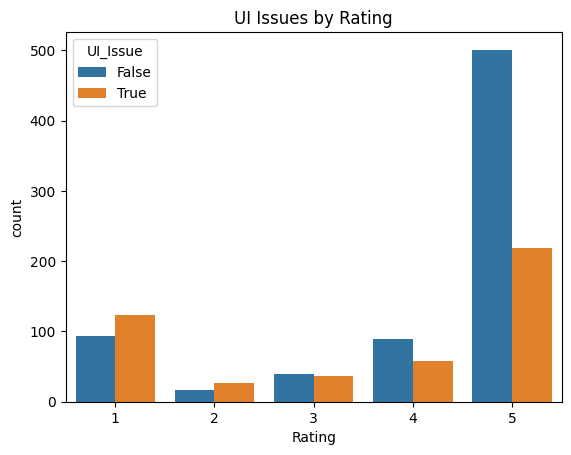

In [147]:
# Common UI complaints
ui_keywords = ['slow', 'lag', 'bug', 'glitch', 'crash', 'freeze', 'complicated', 'hard', 'navigation','unresponsive','delay','latency','stutter',
               'load time','resource intensive','memory leak','instability','error','failure','hang','confusing','difficult','intricate','unintuitive','cumbersome',
               'tedious','user-friendly','accessibility','workflow','steps','process','layout','design','interface','discoverability','pixelated','distorted',
               'alignment','animation','responsiveness','touch','click','scroll','visual','rendering','display','font','color','data loss','sync','save',
               'input','output','search','filter','functionality','feature','compatibility','frustrating','annoying','irritating','problem','issue','bad',
               'poor','broken','useless','disappointing'
]
df['UI_Issue'] = df['Review'].str.contains('|'.join(ui_keywords), case=False)

# % of negative reviews mentioning UI
ui_negative_pct = df[df['Sentiment'] == 'Negative']['UI_Issue'].mean() * 100
print(f"{ui_negative_pct:.1f}% of negative reviews mention UI issues")

# Plot
sns.countplot(data=df, x='Rating', hue='UI_Issue')
plt.title("UI Issues by Rating")
plt.show()

In [148]:
# Filter negative reviews (1-3 stars)
negative_reviews = df[df['Rating'] <= 3].copy()

# Define UI/UX-related keywords
ui_keywords = [
    'ui', 'ux', 'design', 'interface', 'layout', 'navigation', 'confusing', 'complicated', 'cluttered', 'ugly', 'slow',
    'lag', 'bug', 'glitch', 'freeze', 'crash', 'unresponsive','hard to use', 'not intuitive', 'frustrating', 'annoying','hard to navigate', 'slow loading', 
    'confusing layout','crashes frequently', 'ugly design','unresponsive buttons','too many clicks', 'laggy', 'cluttered''slow', 'lag', 'bug', 
    'glitch', 'crash', 'freeze', 'complicated', 'hard', 'navigation','unresponsive','delay','latency','stutter','load time','resource intensive',
    'memory leak','instability','error','failure','hang','confusing','difficult','intricate','unintuitive','cumbersome',
    'tedious','user-friendly','accessibility','workflow','steps','process','layout','design','interface','discoverability','pixelated','distorted',
    'alignment','animation','responsiveness','touch','click','scroll','visual','rendering','display','font','color','data loss','sync','save',
    'input','output','search','filter','functionality','feature','compatibility','frustrating','annoying','irritating','problem','issue','bad',
    'poor','broken','useless','disappointing'
]


# Flag reviews mentioning UI issues
negative_reviews['UI_Complaint'] = negative_reviews['Review'].str.contains(
    '|'.join(ui_keywords), 
    case=False, 
    regex=True
)

# Calculate % of negative reviews mentioning UI
ui_complaint_pct = negative_reviews['UI_Complaint'].mean() * 100
print(f"🔴 **{ui_complaint_pct:.1f}% of negative reviews mention UI/UX issues**")

🔴 **58.3% of negative reviews mention UI/UX issues**


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Only analyze reviews with UI complaints
ui_complaints = negative_reviews[negative_reviews['UI_Complaint']]['Review']

# TF-IDF for bigrams (phrases like "hard to navigate")
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # single words + 2-word phrases
    max_features=50
)

tfidf_matrix = tfidf.fit_transform(ui_complaints)
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Top 10 UI complaints
top_ui_complaints = pd.DataFrame(
    sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:15],
    columns=['Complaint', 'TF-IDF Score']
)

print("🚨 **Top 10 UI/UX Complaints**")
print(top_ui_complaints)

🚨 **Top 10 UI/UX Complaints**
      Complaint  TF-IDF Score
0           app     36.740918
1           ads     27.425937
2          good     14.118844
3       vehicle     12.757994
4       details     12.004926
5   information     11.809043
6        search     11.221694
7       showing     10.309000
8         issue      9.925981
9        number      9.419960
10      challan      9.309737
11         time      9.096416
12         like      9.085206
13         just      8.794728
14       update      8.568055


In [150]:
# Get sentiment for UI complaints
ui_complaints_sentiment = negative_reviews[negative_reviews['UI_Complaint']]['Sentiment_Score']

print("📊 **Sentiment Analysis of UI Complaints**")
print(f"Average Sentiment Score: {ui_complaints_sentiment.mean():.2f} (Very Negative)")
print(f"Most Extreme Complaint: {ui_complaints_sentiment.min():.2f}")

📊 **Sentiment Analysis of UI Complaints**
Average Sentiment Score: -0.07 (Very Negative)
Most Extreme Complaint: -0.97


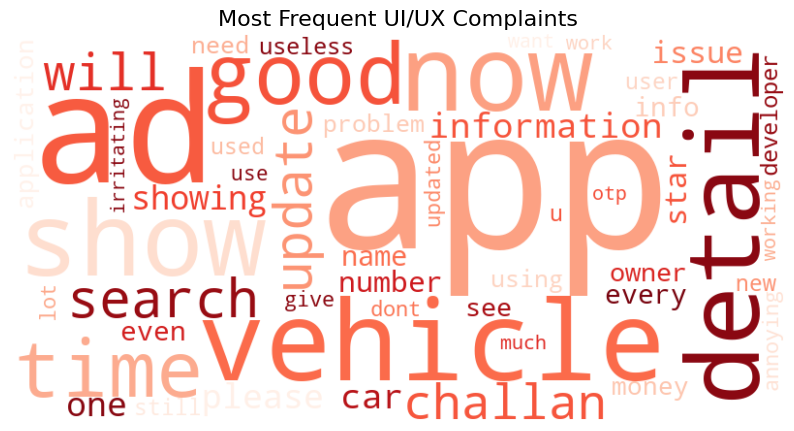

In [151]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all UI complaints into one text
all_ui_complaints = ' '.join(ui_complaints)

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='Reds',  # Red = Negative sentiment
    max_words=50
).generate(all_ui_complaints)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent UI/UX Complaints", fontsize=16)
plt.show()

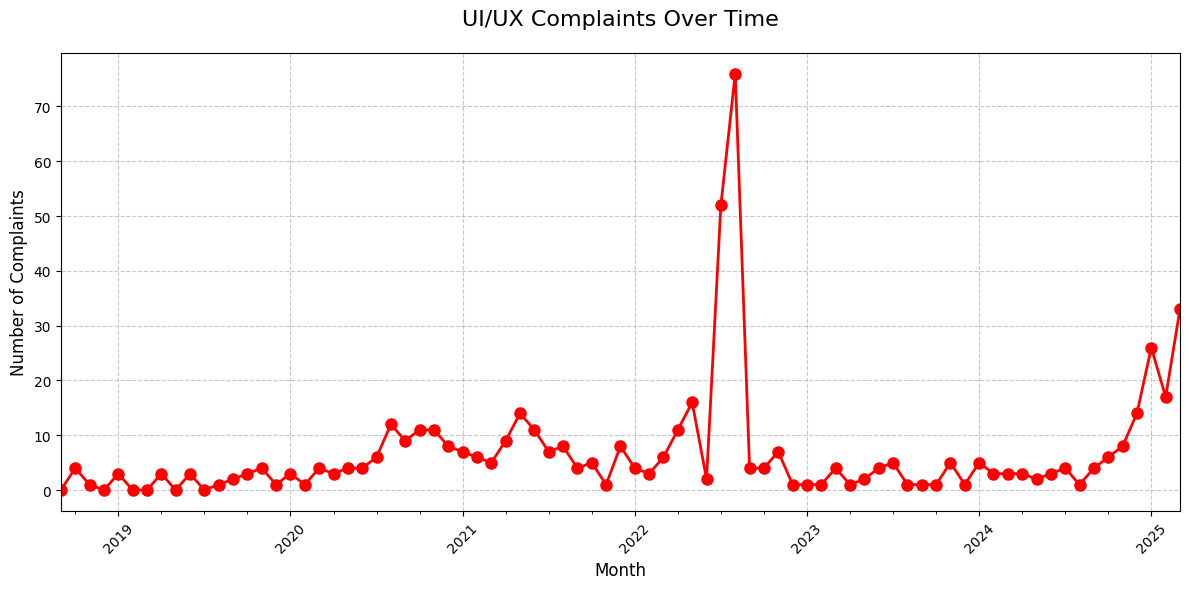


UI Complaint Analysis Summary:
Total UI complaints: 531
Percentage of all reviews: 44.2%
Month with most complaints: 2022-08 (76 complaints)


In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Create the UI complaint flag (handles missing values)
df['UI_Complaint'] = df['Review'].apply(
    lambda x: bool(re.search('|'.join(ui_keywords), str(x).lower())) 
    if pd.notnull(x) else False
)

# 2. Now analyze trends only if we have the required columns
required_columns = ['Date', 'UI_Complaint']
if all(col in df.columns for col in required_columns):
    
    # Convert to datetime and extract month
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Month'] = df['Date'].dt.to_period('M')
    
    # Calculate complaint trends
    ui_complaints_trend = (
        df[df['UI_Complaint']]
        .groupby('Month')
        .size()
        .reindex(pd.period_range(
            start=df['Month'].min(),
            end=df['Month'].max(),
            freq='M'
        ), fill_value=0)
    )
    
    # Plot with improved formatting
    plt.figure(figsize=(12, 6))
    ax = ui_complaints_trend.plot(
        marker='o', 
        color='red',
        linewidth=2,
        markersize=8
    )
    
    # Formatting
    plt.title("UI/UX Complaints Over Time", fontsize=16, pad=20)
    plt.ylabel("Number of Complaints", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels if needed
    if len(ui_complaints_trend) > 6:
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nUI Complaint Analysis Summary:")
    print(f"Total UI complaints: {df['UI_Complaint'].sum()}")
    print(f"Percentage of all reviews: {df['UI_Complaint'].mean()*100:.1f}%")
    print(f"Month with most complaints: {ui_complaints_trend.idxmax()} ({ui_complaints_trend.max()} complaints)")
    
else:
    missing = [col for col in required_columns if col not in df.columns]
    print(f"Cannot analyze - missing columns: {missing}")

In [153]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,"[application, cool, helpful, searches, driving...",True,True,2019-10
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,"[app, lot, information, however, ads, major, p...",True,True,2020-12
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,"[app, useful, efficient, problem, pictures, ve...",True,True,2020-08
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,"[app, amazing, performance, poor, took, insura...",True,True,2025-03
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,"[great, app, good, downloads, ratings, use, th...",True,True,2025-02


In [154]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,"[application, cool, helpful, searches, driving...",True,True,2019-10
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,"[app, lot, information, however, ads, major, p...",True,True,2020-12
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,"[app, useful, efficient, problem, pictures, ve...",True,True,2020-08
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,"[app, amazing, performance, poor, took, insura...",True,True,2025-03
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,"[great, app, good, downloads, ratings, use, th...",True,True,2025-02


Performance & Bug Detection Analytics

In [155]:
# Define performance-related keywords
performance_keywords = [
    'crash','freeze','lag','slow','bug','glitch','not responding','stuck','hangs',
    'loading','performance','unstable','error','delay','latency','stutter','load time',
    'resource intensive','memory leak','instability','failure','unresponsive','rendering','optimization'
]

# Flag reviews mentioning performance issues
df['Performance_Issue'] = df['Review'].str.contains(
    '|'.join(performance_keywords), 
    case=False, 
    regex=True
)

# Calculate percentage
performance_pct = df['Performance_Issue'].mean() * 100
print(f"🚨 {performance_pct:.1f}% of reviews mention performance issues")

# Breakdown by rating
performance_by_rating = df.groupby('Rating')['Performance_Issue'].mean() * 100
print("\nPerformance Issues by Rating:")
print(performance_by_rating)

🚨 5.2% of reviews mention performance issues

Performance Issues by Rating:
Rating
1    10.648148
2    11.904762
3    10.666667
4     6.122449
5     2.500000
Name: Performance_Issue, dtype: float64


Feature Requests & Missing Functionalities Analysis

In [156]:
import re
from collections import Counter

# Define feature request indicators
request_phrases = [
    'should have','need','want','please add','where is','why no','missing','would love','wish there was','suggest','recommend',
    'hope to see','require','desire','looking for','could use','it would be great if','it would be helpful if','is there a way to',
    'is it possible to','consider adding','Id like to see',
    'Im trying to find','can you implement','how do I','is it possible to get','is there','Im looking for'
]

# Filter reviews containing feature requests
feature_requests = df[df['Review'].str.contains('|'.join(request_phrases), case=False, na=False)].copy()

print(f"🔍 Found {len(feature_requests)} reviews containing feature requests ({len(feature_requests)/len(df):.1%} of total)")

# Extract requested features using NLP patterns
def extract_feature_requests(text):
    patterns = [
        r'(?:should have|need|want|please add|wish there was) (.+?)[\.\?!]',
        r'(?:why no|where is) (.+?)[\.\?!]',
        r'(?:missing) (.+?)[\.\?!]'
    ]
    features = []
    for pattern in patterns:
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        features.extend([match.strip() for match in matches])
    return features

feature_requests['Extracted_Features'] = feature_requests['Review'].apply(extract_feature_requests)

🔍 Found 281 reviews containing feature requests (23.4% of total)


In [157]:
# Identify negative reviews mentioning missing features
negative_reviews = df[df['Rating'] <= 3]
negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(
    r'\b(missing|lack|no|without|where is|why no)\b.+?\b(feature|functionality|option)\b', 
    case=False
)

missing_feature_pct = negative_reviews['Missing_Feature'].mean() * 100
print(f"\n🔴 {missing_feature_pct:.1f}% of negative reviews cite missing features")

# Compare to positive reviews
if 'Rating' in df.columns:
    positive_reviews = df[df['Rating'] >= 4]
    pos_missing_pct = positive_reviews['Review'].str.contains(
        r'would love|wish there was|hope to see', 
        case=False
    ).mean() * 100
    
    print(f"🟢 Only {pos_missing_pct:.1f}% of positive reviews mention desired features")
    print(f"⭐ Gap: {missing_feature_pct - pos_missing_pct:.1f} percentage points")

C:\Users\om\AppData\Local\Temp\ipykernel_10116\4150769296.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(
C:\Users\om\AppData\Local\Temp\ipykernel_10116\4150769296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(



🔴 1.5% of negative reviews cite missing features
🟢 Only 0.3% of positive reviews mention desired features
⭐ Gap: 1.2 percentage points


Customer Support & Responsiveness Analytics

🚨 23.7% of all reviews mention customer support issues

Support Complaints by Rating:
Rating
1    21.759259
2    30.952381
3    30.666667
4    28.571429
5    22.083333
Name: Support_Complaint, dtype: float64


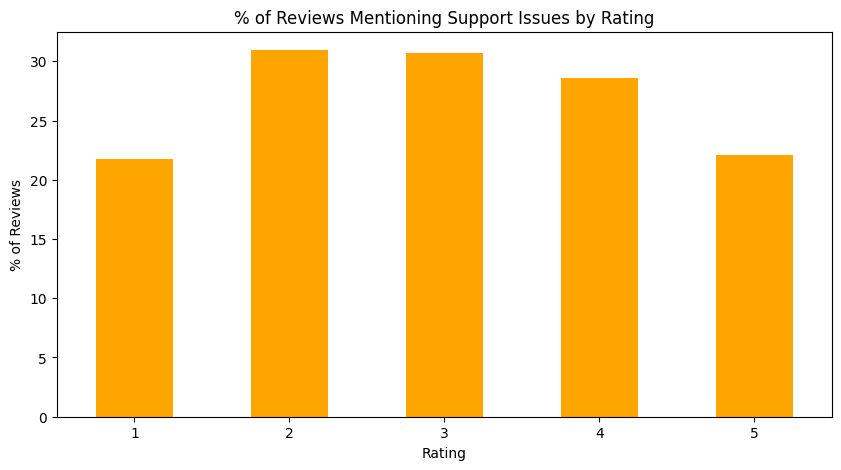

In [158]:
# Define customer support keywords
support_keywords = ['support','customer service','help','contact','response','team','reply','no answer','ignored','no help',
    'terrible service','assistance','feedback','ticket','issue','resolution','agent','representative','email','phone','chat',
    'live chat','forum','documentation','knowledge base','escalate','follow up','wait time','availability','inquiry','problem','complaint',
    'dissatisfied','unhelpful','ineffective','slow response','lack of support','poor service','account support','technical support','billing support'
]

# Flag reviews mentioning support issues
df['Support_Complaint'] = df['Review'].str.contains(
    '|'.join(support_keywords), 
    case=False, 
    na=False
)

# Calculate complaint frequency
support_complaint_pct = df['Support_Complaint'].mean() * 100
support_by_rating = df.groupby('Rating')['Support_Complaint'].mean() * 100

print(f"🚨 {support_complaint_pct:.1f}% of all reviews mention customer support issues")
print("\nSupport Complaints by Rating:")
print(support_by_rating)

# Plot
plt.figure(figsize=(10, 5))
support_by_rating.plot(kind='bar', color='orange')
plt.title("% of Reviews Mentioning Support Issues by Rating")
plt.ylabel("% of Reviews")
plt.xticks(rotation=0)
plt.show()


⏱️ Average response time to negative reviews: -29.4 days
⏱️ Median response time: 3.0 days


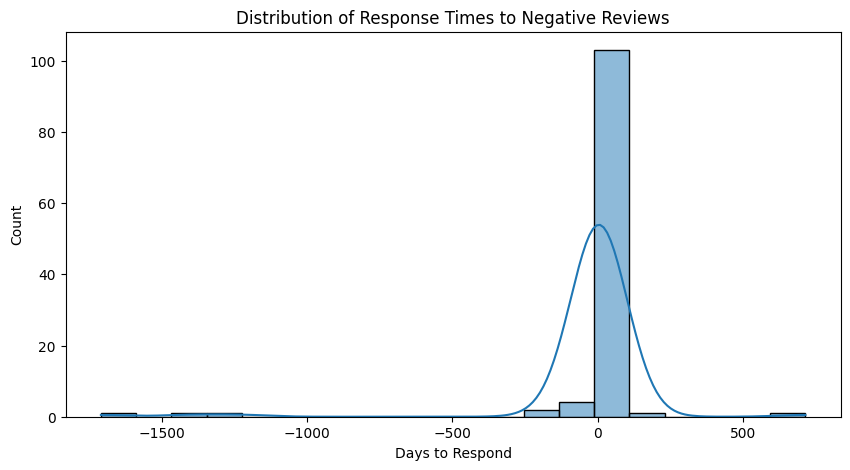

In [159]:
# Calculate response time in days (only for replied reviews)
df['Response_Time_Days'] = (df['Reply Date'] - df['Date']).dt.days

# Analyze response time for negative reviews
negative_with_replies = df[(df['Rating'] <= 3) & (df['Reply'] != "No Reply")]
avg_response_time = negative_with_replies['Response_Time_Days'].mean()
median_response_time = negative_with_replies['Response_Time_Days'].median()

print(f"\n⏱️ Average response time to negative reviews: {avg_response_time:.1f} days")
print(f"⏱️ Median response time: {median_response_time:.1f} days")

# Distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(negative_with_replies['Response_Time_Days'], bins=20, kde=True)
plt.title("Distribution of Response Times to Negative Reviews")
plt.xlabel("Days to Respond")
plt.show()


😊 Average sentiment score for replied reviews: 0.32
😠 Average sentiment score for non-replied reviews: 0.44
📈 Difference: -0.12 points


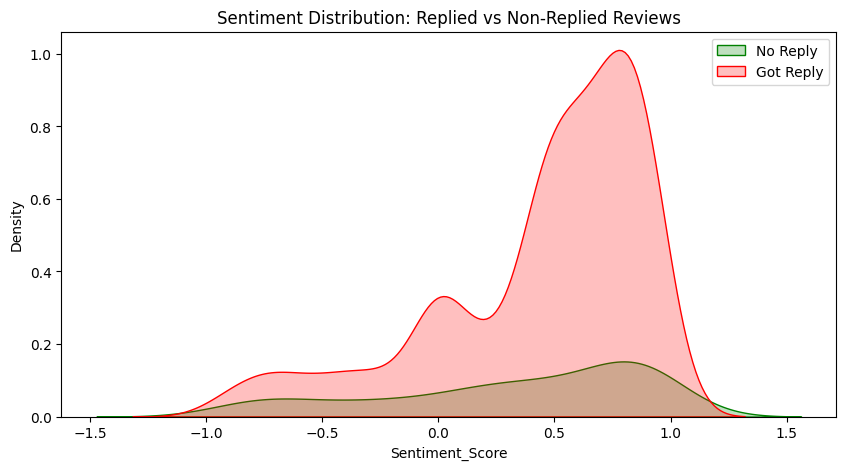

In [160]:
# Compare sentiment between replied vs non-replied reviews
if 'Sentiment_Score' in df.columns:
    replied_sentiment = df[df['Reply'] != "No Reply"]['Sentiment_Score'].mean()
    non_replied_sentiment = df[df['Reply'] == "No Reply"]['Sentiment_Score'].mean()
    
    print(f"\n😊 Average sentiment score for replied reviews: {replied_sentiment:.2f}")
    print(f"😠 Average sentiment score for non-replied reviews: {non_replied_sentiment:.2f}")
    print(f"📈 Difference: {replied_sentiment - non_replied_sentiment:.2f} points")

    # Sentiment distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x='Sentiment_Score', hue=(df['Reply'] != "No Reply"), 
                palette=['red', 'green'], fill=True)
    plt.title("Sentiment Distribution: Replied vs Non-Replied Reviews")
    plt.legend(['No Reply', 'Got Reply'])
    plt.show()

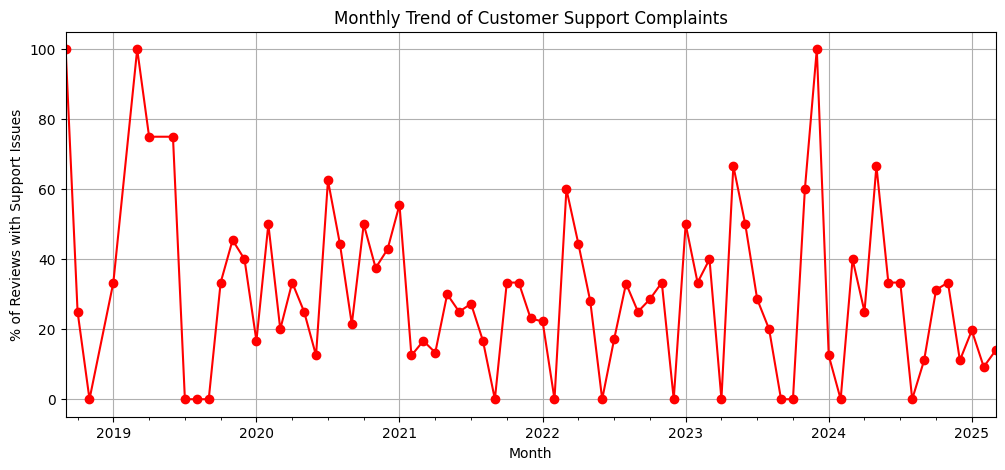

In [161]:
if 'Date' in df.columns:
    # Monthly trend of support complaints
    df['Month'] = df['Date'].dt.to_period('M')
    monthly_support = df.groupby('Month')['Support_Complaint'].mean() * 100
    
    # Plot
    plt.figure(figsize=(12, 5))
    monthly_support.plot(marker='o', color='red')
    plt.title("Monthly Trend of Customer Support Complaints")
    plt.ylabel("% of Reviews with Support Issues")
    plt.grid(True)
    plt.show()

In [162]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month,Performance_Issue,Support_Complaint,Response_Time_Days
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,"[application, cool, helpful, searches, driving...",True,True,2019-10,False,True,1128.0
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,"[app, lot, information, however, ads, major, p...",True,True,2020-12,True,True,714.0
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,"[app, useful, efficient, problem, pictures, ve...",True,True,2020-08,False,True,NaN
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,"[app, amazing, performance, poor, took, insura...",True,True,2025-03,True,False,NaN
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,"[great, app, good, downloads, ratings, use, th...",True,True,2025-02,False,True,NaN


In [163]:
# Priority calculation
support_priority = {
    'Issue': ['Slow response', 'Unhelpful replies', 'No response'],
    'Frequency': [
        (df['Response_Time_Days'] > 7).mean() * 100,
        df[df['Reply'] != "No Reply"]['Review'].str.contains('not helpful|did not solve', case=False).mean() * 100,
        (df['Reply'] == "No Reply").mean() * 100
    ]
}
pd.DataFrame(support_priority).sort_values('Frequency', ascending=False)

,Issue,Frequency
2,No response,81.916667
0,Slow response,5.000000
1,Unhelpful replies,0.000000


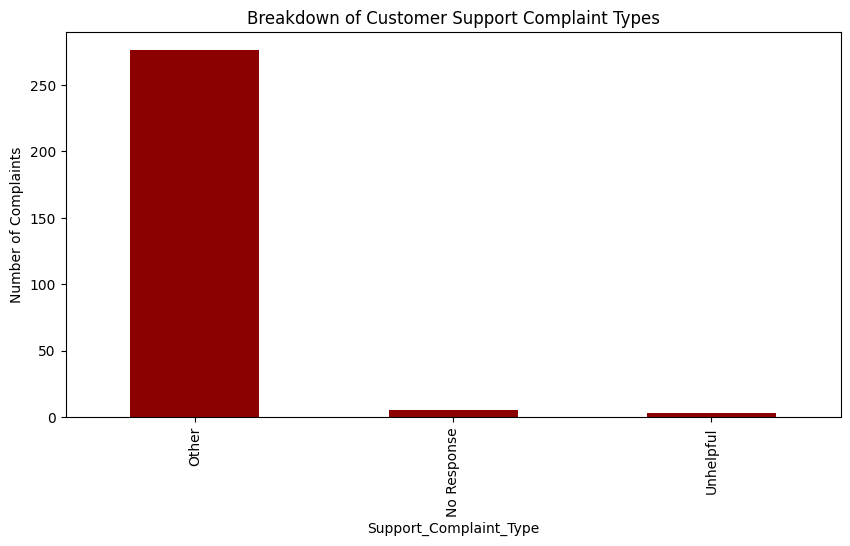

In [164]:
# Classify support complaints into categories
support_categories = {
    'No Response': ['no reply', 'no answer', 'ignored', 'no help', 'no response', 'never responded', 'no feedback'],
    'Slow Response': ['slow response', 'took long', 'days to reply', 'delayed response', 'long wait', 'prolonged delay', 'late reply'],
    'Unhelpful': ['not helpful', 'useless', 'did not solve', 'waste of time', 'ineffective', 'unhelpful', 'did not assist', 'no solution', 'failed to resolve'],
    'Rude Staff': ['rude', 'arrogant', 'unprofessional', 'angry', 'impolite', 'disrespectful', 'hostile', 'offensive', 'dismissive']
}

# Tag each support complaint
def categorize_complaint(text):
    text = str(text).lower()
    for category, keywords in support_categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

df['Support_Complaint_Type'] = df[df['Support_Complaint']]['Review'].apply(categorize_complaint)

# Plot complaint types
plt.figure(figsize=(10, 5))
df['Support_Complaint_Type'].value_counts().plot(kind='bar', color='darkred')
plt.title("Breakdown of Customer Support Complaint Types")
plt.ylabel("Number of Complaints")
plt.show()

In [181]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,...,Performance_Issue,Support_Complaint,Response_Time_Days,Support_Complaint_Type,Response_Tier,Pricing_Complaint,Subscription_Complaint,Subscription_Issue_Type,Review_Count,User_Type
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,...,False,True,1128.0,Other,>2 weeks,False,False,NaN,65,Loyal
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,...,True,True,714.0,Other,>2 weeks,True,False,NaN,1,First-Time
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,...,False,True,NaN,Other,NaN,False,False,NaN,1,First-Time
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,...,True,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,...,False,True,NaN,Other,NaN,True,True,Other,1,First-Time


In [165]:
import numpy as np
# Define response time tiers
bins = [0, 1, 3, 7, 14, np.inf]
labels = ['<1 day', '1-3 days', '4-7 days', '1-2 weeks', '>2 weeks']
df['Response_Tier'] = pd.cut(df['Response_Time_Days'], bins=bins, labels=labels)

# Response time distribution
response_dist = df[df['Reply'] != "No Reply"]['Response_Tier'].value_counts(normalize=True) * 100
print("Response Time Distribution:")
print(response_dist)

# Impact on rating
response_rating = df.groupby('Response_Tier')['Rating'].mean()
print("\nAverage Rating by Response Time:")
print(response_rating)

Response Time Distribution:
Response_Tier
4-7 days     30.337079
1-3 days     26.966292
1-2 weeks    21.348315
>2 weeks     12.359551
<1 day        8.988764
Name: proportion, dtype: float64

Average Rating by Response Time:
Response_Tier
<1 day       1.687500
1-3 days     3.479167
4-7 days     3.203704
1-2 weeks    2.815789
>2 weeks     3.500000
Name: Rating, dtype: float64


C:\Users\om\AppData\Local\Temp\ipykernel_10116\861654891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_rating = df.groupby('Response_Tier')['Rating'].mean()


<Axes: title={'center': 'Weekly Support Metrics'}, xlabel='Date'>

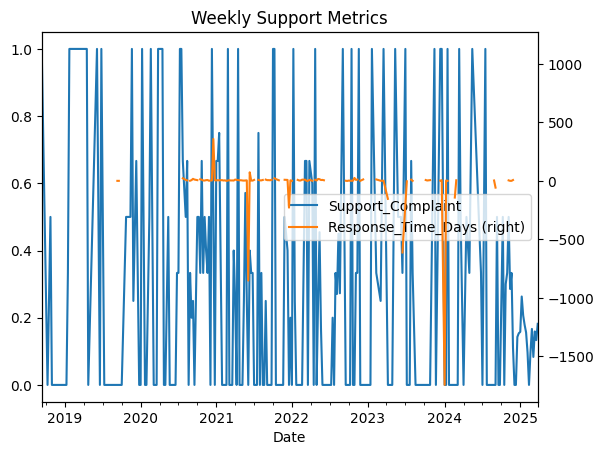

In [166]:
# Weekly support metrics
(df.groupby(df['Date'].dt.to_period('W'))
   .agg({'Support_Complaint': 'mean', 'Response_Time_Days': 'median'})
   .plot(secondary_y='Response_Time_Days', title="Weekly Support Metrics"))

In [167]:
# Key Metrics Summary
support_kpis = {
    'Current Response Time (Days)': df['Response_Time_Days'].median(),
    'Target Response Time': 2,
    'Complaint Rate': df['Support_Complaint'].mean() * 100,
    'Target Complaint Rate': 15,
    'Reply Coverage': (df['Reply'] != "No Reply").mean() * 100,
    'Target Coverage': 90,
    'Positive Reply Impact': replied_sentiment - non_replied_sentiment
}

kpi_df = pd.DataFrame.from_dict(support_kpis, orient='index', columns=['Value'])
kpi_df['Status'] = np.where(
    (kpi_df.index.str.contains('Time|Rate')) & (kpi_df['Value'] > kpi_df['Value'].shift(-1)),
    '❌ Needs Improvement',
    '✅ On Track'
)

print("\n📊 Customer Support KPI Dashboard:")
print(kpi_df)

# Automated Alert System
if support_kpis['Current Response Time (Days)'] > 3:
    print("\n🔴 ALERT: Response times exceeding 3-day target!")
if support_kpis['Complaint Rate'] > 25:
    print("🔴 ALERT: Support complaint rate above 25%!")


📊 Customer Support KPI Dashboard:
                                  Value               Status
Current Response Time (Days)   4.000000  ❌ Needs Improvement
Target Response Time           2.000000           ✅ On Track
Complaint Rate                23.666667  ❌ Needs Improvement
Target Complaint Rate         15.000000           ✅ On Track
Reply Coverage                18.083333           ✅ On Track
Target Coverage               90.000000           ✅ On Track
Positive Reply Impact         -0.121260           ✅ On Track

🔴 ALERT: Response times exceeding 3-day target!


Monetization & Subscription Feedback Analysis

💰 8.4% of reviews mention pricing issues

Pricing Complaints by Rating:
Rating
1    17.129630
2    11.904762
3    10.666667
4     8.163265
5     5.416667
Name: Pricing_Complaint, dtype: float64


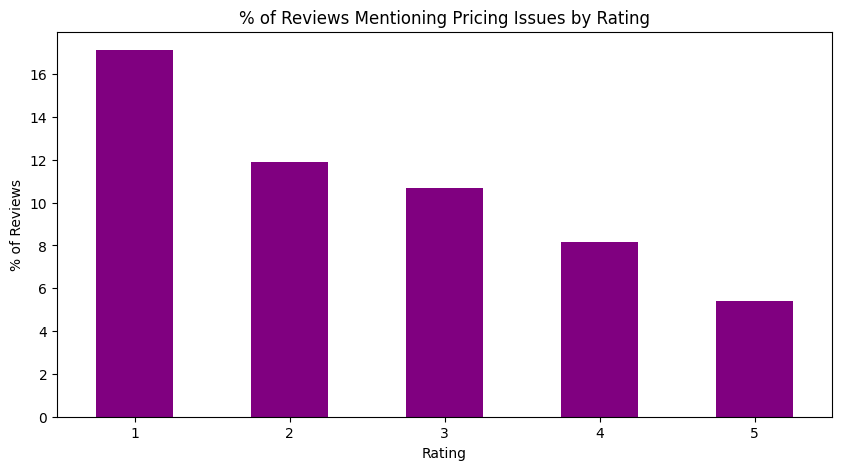

In [168]:
# Define pricing-related keywords
pricing_keywords = ['expensive','overpriced','pricey','too much','not worth','high price','cost too much','unfair','cheaper','lower price',
    'reduce price','price hike','cost','value','affordable','budget','premium','subscription','billing','payment','discount',
    'sale','refund','charge','fees','rates','economical','reasonable','inaccessible','exorbitant','rip off','free trial',
    'hidden fees','monthly cost','yearly cost','value for money'
]
# Flag pricing complaints
df['Pricing_Complaint'] = df['Review'].str.contains(
    '|'.join(pricing_keywords), 
    case=False, 
    na=False
)

# Calculate pricing complaint metrics
pricing_complaint_pct = df['Pricing_Complaint'].mean() * 100
pricing_by_rating = df.groupby('Rating')['Pricing_Complaint'].mean() * 100

print(f"💰 {pricing_complaint_pct:.1f}% of reviews mention pricing issues")
print("\nPricing Complaints by Rating:")
print(pricing_by_rating)

# Plot
plt.figure(figsize=(10, 5))
pricing_by_rating.plot(kind='bar', color='purple')
plt.title("% of Reviews Mentioning Pricing Issues by Rating")
plt.ylabel("% of Reviews")
plt.xticks(rotation=0)
plt.show()

In [169]:
# # Compare pricing complaints before/after price changes
# if 'Date' in df.columns:
#     # Example: Price change occurred on 2024-01-15
#     price_change_date = pd.to_datetime('2024-01-15')
#     df['Post_Price_Change'] = df['Date'] > price_change_date
    
#     pricing_complaint_change = df.groupby('Post_Price_Change')['Pricing_Complaint'].mean() * 100
#     print("\nPricing Complaints Before vs After Price Change:")
#     print(pricing_complaint_change)


🔄 5.2% of reviews mention subscription/IAP issues

Subscription Complaints by Rating:
Rating
1    16.203704
2     9.523810
3     1.333333
4     1.360544
5     2.777778
Name: Subscription_Complaint, dtype: float64


<Figure size 800x500 with 0 Axes>

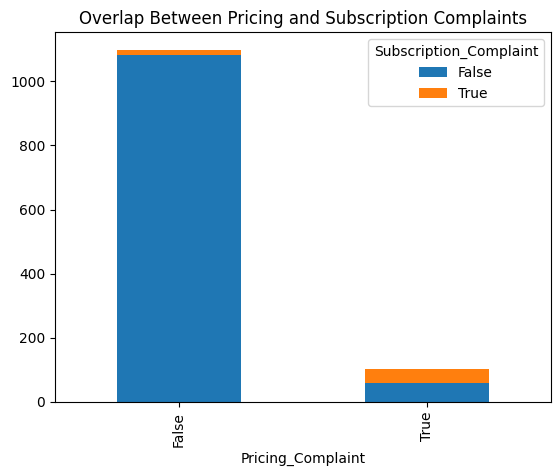

In [170]:
# Define subscription/IAP keywords
subscription_keywords = ['subscription','renewal','auto-renew','cancel','refund','billing','charge','payment','iap','in-app purchase',
    'trial','scam','unsubscribe','manage subscription','subscription fees','subscription cost','subscription service','membership',
    'recurring payment','subscription plan','subscription model','subscription options','subscription terms','subscription issues',
    'subscription problems','subscription error','subscription expired','subscription active','subscription paused','subscription status',
    'subscription details','subscription access','subscription account','subscription support','subscription help','subscription cancellation',
    'subscription confirmation','subscription history','subscription information'
]

# Flag subscription complaints
df['Subscription_Complaint'] = df['Review'].str.contains(
    '|'.join(subscription_keywords), 
    case=False, 
    na=False
)

# Calculate metrics
subscription_complaint_pct = df['Subscription_Complaint'].mean() * 100
subscription_by_rating = df.groupby('Rating')['Subscription_Complaint'].mean() * 100

print(f"\n🔄 {subscription_complaint_pct:.1f}% of reviews mention subscription/IAP issues")
print("\nSubscription Complaints by Rating:")
print(subscription_by_rating)

# Plot overlap between pricing and subscription complaints
plt.figure(figsize=(8, 5))
pd.crosstab(df['Pricing_Complaint'], df['Subscription_Complaint']).plot(
    kind='bar', stacked=True, 
    title="Overlap Between Pricing and Subscription Complaints"
)
plt.show()

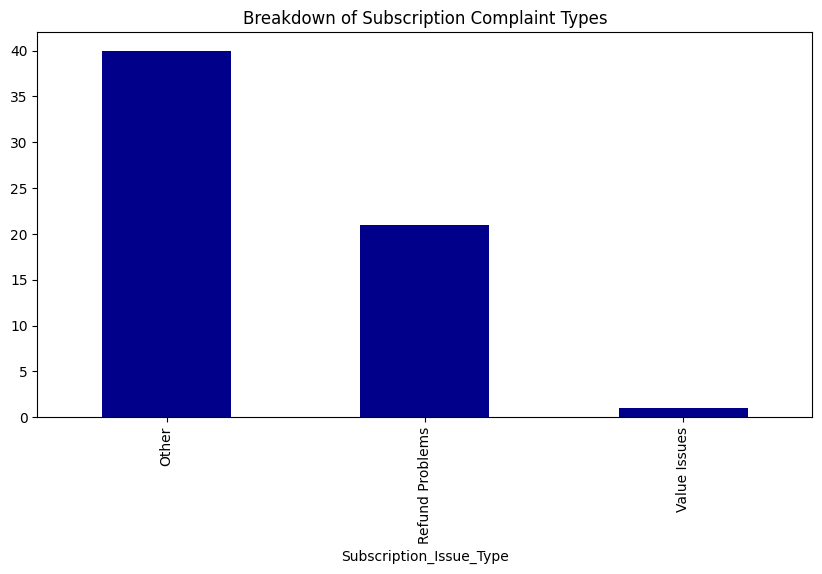

In [171]:
# Extract specific subscription issues
subscription_issues = {
    'Auto-Renewal': ['auto-renew', 'unsubscribe', 'hard to cancel', 'difficult to cancel', 'automatic renewal', 'cancellation problems', 'cannot unsubscribe'],
    'Unexpected Charges': ['unexpected charge', 'hidden fee', 'surprise charge', 'unauthorized charge', 'extra fees', 'unknown charge', 'incorrect billing'],
    'Refund Problems': ['refund', 'money back', 'not refund', 'no refund', 'refund denied', 'refund issues', 'refund process', 'refund policy'],
    'Value Issues': ['not worth', 'waste of money', 'better free', 'overpriced subscription', 'poor value', 'not worth the cost', 'expensive for what it offers']
}

# Categorize subscription complaints
def categorize_sub_issue(text):
    text = str(text).lower()
    for category, keywords in subscription_issues.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

df['Subscription_Issue_Type'] = df[df['Subscription_Complaint']]['Review'].apply(categorize_sub_issue)

# Plot issue distribution
plt.figure(figsize=(10, 5))
df['Subscription_Issue_Type'].value_counts().plot(kind='bar', color='darkblue')
plt.title("Breakdown of Subscription Complaint Types")
plt.show()

In [172]:
df.columns

Index(['Username', 'Rating', 'Date', 'Review', 'Usefulness', 'Reply',
       'Reply Date', 'Reply_Time_Days', 'Sentiment_Score', 'Sentiment',
       'Tokens', 'UI_Issue', 'UI_Complaint', 'Month', 'Performance_Issue',
       'Support_Complaint', 'Response_Time_Days', 'Support_Complaint_Type',
       'Response_Tier', 'Pricing_Complaint', 'Subscription_Complaint',
       'Subscription_Issue_Type'],
      dtype='object')

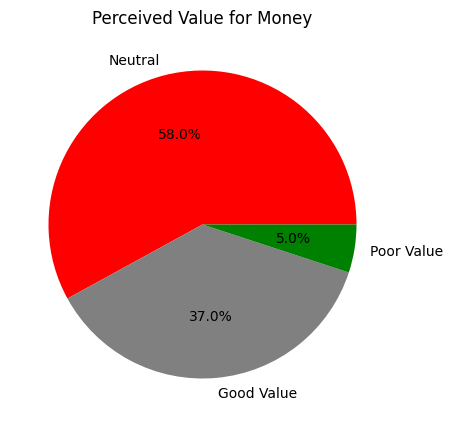

In [173]:
# Isolate reviews discussing pricing
pricing_reviews = df[df['Pricing_Complaint'] | df['Subscription_Complaint']].copy()

# Calculate value sentiment
pricing_reviews['Value_Sentiment'] = pricing_reviews['Review'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

# Categorize value perception
bins = [-1, -0.3, 0.3, 1]
labels = ['Poor Value', 'Neutral', 'Good Value']
pricing_reviews['Value_Perception'] = pd.cut(
    pricing_reviews['Value_Sentiment'], 
    bins=bins, 
    labels=labels
)

# Plot distribution
plt.figure(figsize=(8, 5))
pricing_reviews['Value_Perception'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',
    colors=['red', 'gray', 'green']
)
plt.title("Perceived Value for Money")
plt.ylabel("")
plt.show()

2025-03-27 21:09:42,741 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 21:09:42,749 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 21:09:42,758 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 21:09:42,765 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-27 21:09:42,813 : INFO : Using categorical units to plot a list of strings that are all parsable as 

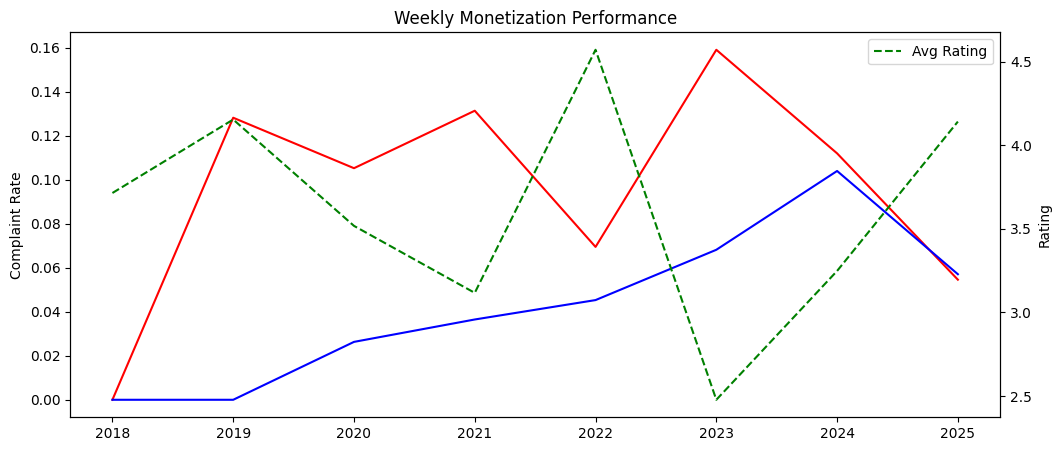

In [174]:
# Key metrics to track weekly
monetization_kpis = df.groupby(df['Date'].dt.to_period('Y')).agg({
    'Pricing_Complaint': 'mean',
    'Subscription_Complaint': 'mean',
    'Rating': 'mean'
})

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monetization_kpis.index.astype(str), monetization_kpis['Pricing_Complaint'], 'r-', label='Pricing Complaints')
ax1.plot(monetization_kpis.index.astype(str), monetization_kpis['Subscription_Complaint'], 'b-', label='Subscription Complaints')
ax2 = ax1.twinx()
ax2.plot(monetization_kpis.index.astype(str), monetization_kpis['Rating'], 'g--', label='Avg Rating')
ax1.set_ylabel('Complaint Rate')
ax2.set_ylabel('Rating')
plt.title("Weekly Monetization Performance")
plt.legend()
plt.show()

Sentiment Analysis & User Retention Deep Dive

In [175]:
# Detect loyal users (those with multiple reviews)
review_counts = df['Username'].value_counts()
df['Review_Count'] = df['Username'].map(review_counts)
df['User_Type'] = np.where(df['Review_Count'] > 1, 'Loyal', 'First-Time')

# Calculate proportions
user_type_pct = df['User_Type'].value_counts(normalize=True) * 100
print(f"👥 User Composition:\n{user_type_pct}")

# Compare sentiment
loyalty_sentiment = df.groupby('User_Type')['Sentiment_Score'].mean()
print(f"\n😊 Average Sentiment:\n{loyalty_sentiment}")

👥 User Composition:
User_Type
First-Time    93.583333
Loyal          6.416667
Name: proportion, dtype: float64

😊 Average Sentiment:
User_Type
First-Time    0.406387
Loyal         0.613300
Name: Sentiment_Score, dtype: float64



📈 Loyal Users' Rating Changes:
Rating_Change
 0.0    36
 1.0    11
-1.0    10
 2.0     3
-4.0     3
 4.0     2
-3.0     2
 3.0     2
-2.0     1
Name: count, dtype: int64


C:\Users\om\AppData\Local\Temp\ipykernel_10116\1610781129.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


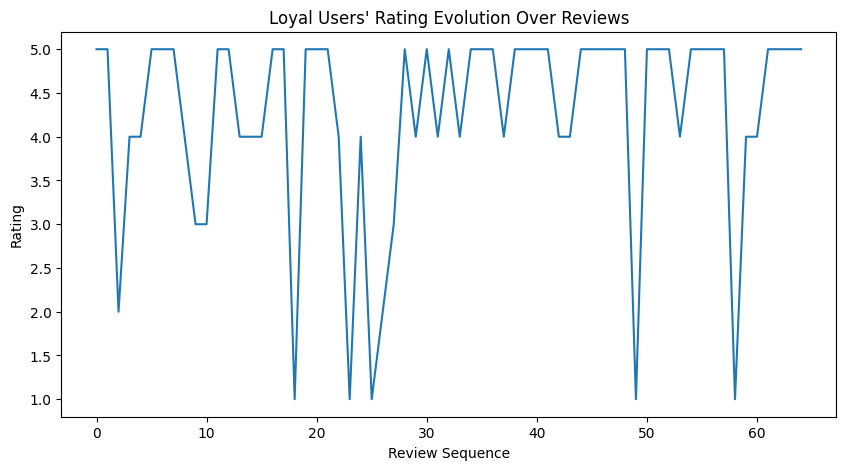

In [176]:
# Track loyal users' rating changes over time
if 'Date' in df.columns and 'User_Type' in df.columns:
    loyal_users = df[df['User_Type'] == 'Loyal'].sort_values(['Username', 'Date'])
    loyal_users['Rating_Change'] = loyal_users.groupby('Username')['Rating'].diff()
    
    print("\n📈 Loyal Users' Rating Changes:")
    print(loyal_users['Rating_Change'].value_counts())
    
    # Plot rating evolution
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=loyal_users,
        x=loyal_users.groupby('Username').cumcount(),
        y='Rating',
        ci=None,
        estimator='median'
    )
    plt.title("Loyal Users' Rating Evolution Over Reviews")
    plt.xlabel("Review Sequence")
    plt.ylabel("Rating")
    plt.show()

 Actionable Insights Generator

In [180]:
df.head()

,Username,Rating,Date,Review,Usefulness,Reply,Reply Date,Reply_Time_Days,Sentiment_Score,Sentiment,...,Performance_Issue,Support_Complaint,Response_Time_Days,Support_Complaint_Type,Response_Tier,Pricing_Complaint,Subscription_Complaint,Subscription_Issue_Type,Review_Count,User_Type
0,A Google user,4,2019-10-27,the application is so cool and helpful it sear...,6039,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,1128,0.9709,Positive,...,False,True,1128.0,Other,>2 weeks,False,False,NaN,65,Loyal
1,Sanu Shameer,2,2020-12-14,app has a lot of information however the ads a...,3703,CarInfo - Challans| FASTag | Buy & Sell Cars,2022-11-28,714,0.0979,Positive,...,True,True,714.0,Other,>2 weeks,True,False,NaN,1,First-Time
2,Let's watch movies,3,2020-08-06,this app is very useful and efficient the only...,3624,No Reply,NaT,<NA>,0.9110,Positive,...,False,True,NaN,Other,NaN,False,False,NaN,1,First-Time
3,Faisal faizy1610,3,2025-03-18,before the app was amazing but now its perform...,2,No Reply,NaT,<NA>,-0.4921,Negative,...,True,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
4,Neeraj,5,2025-02-25,this is a great app with good downloads and ra...,80,No Reply,NaT,<NA>,0.8322,Positive,...,False,True,NaN,Other,NaN,True,True,Other,1,First-Time
